In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __future__ import print_function, absolute_import, division
import json
import itertools
import string
import json
import logging
import copy
import collections
import functools
import sys
import random

from IPython.core.getipython import get_ipython
from IPython.core.magic import (Magics, magics_class,  cell_magic)
from StringIO import StringIO
from markdown import markdown
from IPython.core.display import HTML, display

from nltk.corpus import stopwords as _stopwords
from sklearn import (manifold, cluster, metrics, cross_validation, tree, grid_search, ensemble, naive_bayes,
                     preprocessing)
import wordcloud
import gensim as gs
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import pandas as pd

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
np.set_printoptions(precision=5,suppress=True)

In [4]:
@magics_class
class MarkdownMagics(Magics):
 
    @cell_magic
    def asmarkdown(self, line, cell):
        buffer = StringIO()
        stdout = sys.stdout
        sys.stdout = buffer
        try:
            exec(cell, locals(), self.shell.user_ns)
        except:
            sys.stdout = stdout
            raise
        sys.stdout = stdout
        return HTML("<p>{}</p>".format(markdown(buffer.getvalue(), extensions=['markdown.extensions.extra'])))
        return buffer.getvalue() + 'test'
 
get_ipython().register_magics(MarkdownMagics)

In [5]:
D2V_VEC_SIZE = 300

In [6]:
with open('/Users/kahnza2/Documents/data/frataxin_articles.json') as f:
    raw_corpus = json.load(f)

In [7]:
for field in raw_corpus[0].keys():
    print(field, type(raw_corpus[0].get(field)))

abstract <type 'unicode'>
title <type 'unicode'>
pmid <type 'unicode'>
mesh_terms <type 'list'>


## Preprocessing
The abstract and title should be tokenized, with optional preprocessing. There should be an option to add the mesh terms to the string as well. Acronyms should be preserved.

In [8]:
def is_acronym(word):
    """Determine whether a word is an acronym.
    
    Parameters
    -------------
    word:string
    
    Returns
    -------------
    :bool
        True if word is an acronym false if not.
    """
    if word.islower() or len(word)==1 or word.isdigit():
        return False
    elif any([char.isupper() for char in word[1:]]):
        return True
    elif word[0].isupper():
        return False
    else:
        raise ValueError('unmatched pattern in {}'.format(word))

In [9]:
def standardize_words(document, keys=None):
    """Lowercase any words that are not acronyms.
    
    Parameters
    -----------
    document : dict
    keys : iterable of strings
        Each key value must be an iterable of strings.
        
    Returns
    -----------
    :dict
        A copy of the original dictionary with `keys` modified.
    """
    doc_copy = copy.copy(document)
    for key in keys:
        doc_copy[key] = [word for word in doc_copy.get(key) if word]
        doc_copy[key] = [word.lower() if not is_acronym(word) else word for word in doc_copy.get(key)]
    return doc_copy
        

In [10]:
def drop_stopwords(document, keys=None, stopset=None):
    """Removes any occurences for words in `stopset` from `document`.
    
    Parameters
    -----------
    document : dict
    keys : iterable of strings
        Each key value must be an iterable of strings.
    stopset : set
        Contains stopwords.
        
    Returns
    -----------
    :dict
        A copy of the original dictionary with `keys` modified.
    """
    doc_copy = copy.copy(document)
    for key in keys:
        doc_copy[key] = [word for word in doc_copy.get(key) if word not in stopset]
    return doc_copy

In [11]:
def depunc(phrase, pset=set(string.punctuation)):
    return ''.join([char for char in phrase if char not in pset or char])

## doc2vec
Each dict in `raw_corpus` must be changed into a TaggedDocument. In addition, the title and abstract should be concatenated.

In [12]:
#describes the transformation to an iterable
transform_manifest = {key:lambda x: map(depunc,gs.utils.tokenize(x,deacc=True)) for key in ['abstract', 'title']}
transform_manifest['pmid'] = lambda x: int(x)

def apply_transform(in_obj, t_manifest):
    o_obj = copy.copy(in_obj)
    for key, value in t_manifest.iteritems():
        o_obj[key] = value(o_obj.get(key))
    return o_obj

In [13]:
corpus_iterable_strings = [apply_transform(document, transform_manifest) for document in raw_corpus]

In [14]:
stopset = set(_stopwords.words('english'))
corpus = []
keys_to_process = keys=['abstract', 'title']
for idx, _document in enumerate(corpus_iterable_strings):
    document = drop_stopwords(standardize_words(_document, keys=keys),keys=keys, stopset=stopset)
    corpus.append(gs.models.doc2vec.TaggedDocument(
        document['abstract']+document['title'],[idx]))

In [15]:
model = gs.models.Doc2Vec(corpus, size=D2V_VEC_SIZE, window=6, min_count=2, workers=4)
features = np.matrix(model.docvecs)

In [149]:
lle = manifold.LocallyLinearEmbedding(n_components=2, n_neighbors=20)
projection = lle.fit_transform(np.matrix(model.docvecs))

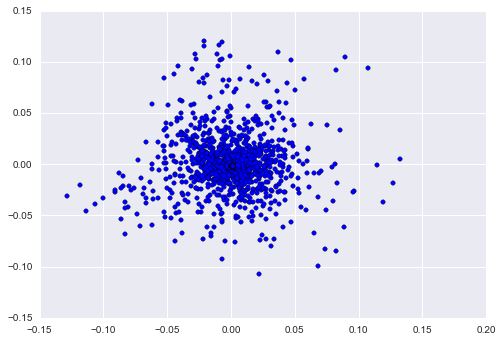

In [150]:
plt.scatter(projection[:,0],projection[:,1])

### Titles for abstracts in the bottom wing:

In [17]:
for idx in np.argsort(projection[:,1])[:15]:
    print(raw_corpus[idx]['title'])

Human frataxin activates Fe-S cluster biosynthesis by facilitating sulfur transfer chemistry.
Functional reconstitution of mitochondrial Fe/S cluster synthesis on Isu1 reveals the involvement of ferredoxin.
Iron-dependent self-assembly of recombinant yeast frataxin: implications for Friedreich ataxia.
Chemistry and biology of eukaryotic iron metabolism.
Coming into view: eukaryotic iron chaperones and intracellular iron delivery.
A dynamic model of the proteins that form the initial iron-sulfur cluster biogenesis machinery in yeast mitochondria.
Components involved in assembly and dislocation of iron-sulfur clusters on the scaffold protein Isu1p.
Drosophila frataxin: an iron chaperone during cellular Fe-S cluster bioassembly.
Iron-sulfur cluster biogenesis in mammalian cells: New insights into the molecular mechanisms of cluster delivery.
Biophysical characterization of the iron in mitochondria from Atm1p-depleted Saccharomyces cerevisiae.
Human iron-sulfur cluster assembly, cellular i

### Titles for abstracts in the top wing

In [18]:
for idx in np.argsort(projection[:,1])[-15:]:
    print(raw_corpus[idx]['title'])

Inferior cerebellar hypoplasia resembling a Dandy-Walker-like malformation in purebred Eurasier dogs with familial non-progressive ataxia: a retrospective and prospective clinical cohort study.
Progressive sensorineural hearing loss in children with mitochondrial encephalomyopathies.
Quantification of upper extremity function using kinematic analysis.
A controlled study of oral vigabatrin (gamma-vinyl GABA) in patients with cerebellar ataxia.
Binaural speech processing in individuals with auditory neuropathy.
Neurophysiological evaluation in children with Friedreich's ataxia.
Friedreich's ataxia: clinical and molecular study of 25 Brazilian cases.
Ataxia rating scales--psychometric profiles, natural history and their application in clinical trials.
Comparison of three clinical rating scales in Friedreich ataxia (FRDA).
Rating disease progression of Friedreich's ataxia by the International Cooperative Ataxia Rating Scale: analysis of a 603-patient database.
Substantia nigra echogenicity

In [19]:
bottomwing = ' '.join(itertools.chain.from_iterable([x.values() for 
 x in  itertools.chain.from_iterable([raw_corpus[idx]['mesh_terms'] for idx in np.argsort(projection[:,1])[:15]])]))

In [20]:
topwing = ' '.join(itertools.chain.from_iterable([x.values() for 
 x in  itertools.chain.from_iterable([raw_corpus[idx]['mesh_terms'] for idx in np.argsort(projection[:,1])[-15:]])]))

In [21]:
%%script false
%matplotlib qt
plt.imshow(wordcloud.WordCloud(background_color='white',width=1000,height=1000, relative_scaling=0.5).generate(topwing))

In [22]:
%%script false
plt.figure()
plt.imshow(wordcloud.WordCloud(background_color='black',width=1000,height=1000, relative_scaling=0.5).generate(bottomwing))

In [23]:
print('| |'.join(bottomwing.split()))

Cysteine| |Humans| |Iron-Binding| |Proteins| |Iron-Sulfur| |Proteins| |Membrane| |Transport| |Proteins| |Protein| |Binding| |Substrate| |Specificity| |Sulfur| |Adrenodoxin| |Biocatalysis| |Chaetomium| |Escherichia| |coli| |Ferredoxin-NADP| |Reductase| |Ferredoxins| |Humans| |Iron-Sulfur| |Proteins| |Membrane| |Proteins| |Mitochondria| |Mitochondrial| |Proteins| |Saccharomyces| |cerevisiae| |Saccharomyces| |cerevisiae| |Proteins| |Sulfurtransferases| |Chromatography,| |Gel| |Escherichia| |coli| |Friedreich| |Ataxia| |Homeostasis| |Humans| |Iron| |Iron| |Chelating| |Agents| |Iron-Binding| |Proteins| |Microscopy,| |Atomic| |Force| |Microscopy,| |Electron| |Mitochondria| |Models,| |Biological| |Molecular| |Sequence| |Data| |Molecular| |Weight| |Oxidative| |Stress| |Phosphotransferases| |(Alcohol| |Group| |Acceptor)| |Protein| |Binding| |Protein| |Structure,| |Quaternary| |Recombinant| |Proteins| |Reducing| |Agents| |Saccharomyces| |cerevisiae| |Solubility| |Animals| |Carrier| |Proteins| |E

In [24]:
print('| |'.join(topwing.split()))

Acoustic| |Impedance| |Tests| |Adolescent| |Adult| |Audiometry,| |Pure-Tone| |Audiometry,| |Speech| |Child,| |Preschool| |Evoked| |Potentials,| |Auditory,| |Brain| |Stem| |Female| |Friedreich| |Ataxia| |Hearing| |Loss,| |Sensorineural| |Humans| |Kearns-Sayre| |Syndrome| |Longitudinal| |Studies| |MELAS| |Syndrome| |Male| |Mitochondrial| |Encephalomyopathies| |Otoacoustic| |Emissions,| |Spontaneous| |Reflex,| |Acoustic| |Adolescent| |Arm| |Ataxia| |Cerebellar| |Neoplasms| |Child| |Female| |Friedreich| |Ataxia| |Humans| |Male| |Motor| |Skills| |Movement| |Adolescent| |Adult| |Aminocaproates| |Double-Blind| |Method| |Drug| |Evaluation| |Friedreich| |Ataxia| |Humans| |Male| |Middle| |Aged| |Neurologic| |Examination| |Olivopontocerebellar| |Atrophies| |Random| |Allocation| |Spinocerebellar| |Degenerations| |Vigabatrin| |Adolescent| |Adult| |Age| |of| |Onset| |Audiometry| |Auditory| |Perception| |Auditory| |Perceptual| |Disorders| |Axons| |Charcot-Marie-Tooth| |Disease| |Child| |Child,| |Pres

### Pure Clusters
The basic idea is to cluster both the word vectors and the document vectors separately, and then attempt to find a cluster of word vectors that occurs mostly in one document cluster. This also means I need to determine the number of clusters. I was thinking about using the ratio of in-group variance to out of group variance.

In [25]:
def cluster_variance(features):
    c_mean = np.mean(features,axis=0)
    l2_distance_rhs = functools.partial(scipy.spatial.distance.sqeuclidean, c_mean)
    return np.var(np.apply_along_axis(l2_distance_rhs,1,features))


def compute_oog_ig_variance(features=None, assignments=None, with_raise=False):
    """Computes the ratio of in group variance to out of group variance.
    
    Parameters
    ------------
    features : numpy.ndarray
        A n_samples x n_features matrix.
    assignments: numpy.ndarray
        A n_samples x 1 matrix.
    
    Returns
    --------
    :list
        A list of group_variance, out_of_group variance tuples.
    """
    rows, cols = features.shape
    try:
        n_samples, _ = assignments.shape
    except ValueError as is_flat_array:
        n_samples, = assignments.shape
    if rows != n_samples:
        raise ValueError('mismatched input lengths {r} {s}'.format(r=rows, s=n_samples))
    
    group_variances = []
    out_of_g_variances = []
    cluster_ids = np.unique(assignments)
    for cluster in cluster_ids:
        group_variance = cluster_variance(features[assignments==cluster])
        group_variances.append(group_variance)
        out_of_group_variance = cluster_variance(features[assignments!=cluster])
        out_of_g_variances.append(out_of_group_variance)
        
        if group_variance>out_of_group_variance and not with_raise:
            logging.warning('possibly ill formed cluster {cid}|{c}:{ig},{og}'.format(
                    cid=len(cluster_ids),c=cluster,ig=group_variance,og=out_of_group_variance))
        elif group_variance>out_of_group_variance and with_raise:
            raise ValueError('possibly ill formed cluster {cid}|{c}:{ig},{og}'.format(
                    cid=len(cluster_ids),c=cluster,ig=group_variance,og=out_of_group_variance))
    
    return np.mean(group_variances),np.mean(out_of_g_variances)

In [26]:
%%script false
cluster_dict = {n_clusters:cluster.AgglomerativeClustering(n_clusters=n_clusters,affinity='cosine',linkage='average')
                for n_clusters in range(2,300,5)}
cluster_dict = {n_clusters:clusterer.fit_predict(features) for n_clusters,clusterer in cluster_dict.iteritems()}

In [27]:
%%script false
cluster_variances = {n_clusters:compute_oog_ig_variance(features,assignments) for n_clusters,assignments in 
                    cluster_dict.iteritems()}

In [28]:
def cls_variance_pretty(cls_asgn_dict=None):
    """Computes cluster variance ratios in a pretty format.
    
    Parameters
    ----------
    cls_asgn_dict:dict
        A dictionary with n_clusters, (ig, oog) variances.
    
    Returns
    ---------
    n_clusters, variance_ratios : tuples
    """
    cluster_ratios = {n_clusters:np.log2((og/ig))  for n_clusters,(ig,og) in cls_asgn_dict.iteritems()}
    return zip(*sorted(list(cluster_ratios.iteritems()),key=lambda x: x[0]))

In [29]:
%%script false
n_clusters, var_ratios = cls_variance_pretty(cluster_variances)
plt.scatter(n_clusters,var_ratios)

In [30]:
#if the clustering algorithm doesn't minimize in group variance, this will drop any parameter setting. So
#run this last or possibly not at all
#cluster_variances_filtered = dict()
#for n_clusters,assignments in cluster_dict.iteritems():
#    try:
#        cluster_variances_filtered[n_clusters] = compute_oog_ig_variance(features,assignments,with_raise=True)
#    except ValueError as exists_ill_formed_cluster:
#        print(exists_ill_formed_cluster)
#        continue
        

In [ ]:
n_clusters, var_ratios = cls_variance_pretty(cluster_variances)
plt.scatter(n_clusters,var_ratios)

In [ ]:
print(np.array(n_clusters)[np.argsort(var_ratios)[::-1]])

### Checking how well the clustering works
I have a "good" number of clusters, and the assignments, I can look through a couple in order to see how well it works on a surface level.

In [ ]:
np.median([len(list(itertools.compress(raw_corpus, cluster_dict[62]==cluster_id))) for cluster_id in range(62)])

In [ ]:
print([len(list(itertools.compress(raw_corpus, cluster_dict[62]==cluster_id))) for cluster_id in range(62)])

In [ ]:
[document['title']  for document in itertools.compress(raw_corpus,cluster_dict[62]==2)]

## Clustering on the words
Same process, will be interesting to see what the words look like. I also have to check whether or not I can figure out what documents each word appears in.

*Hacky solution*:
Once the words are clustered, I can examine each cluster, and check the spread of the documents those words appear in.

In [31]:
word_features = np.matrix(model.syn0)

The next two pieces of code can probably be skipped since I already have an estimate of how many clusters makes sense. I can go with any number between ~250 and 400. They all work fine.

In [32]:
%%script false
word_cls_dict  = {n_clusters:cluster.AgglomerativeClustering(n_clusters=n_clusters,affinity='cosine',linkage='average')
                for n_clusters in [250,350,450]}
word_cls_dict = {n_clusters:clusterer.fit_predict(word_features) for n_clusters,clusterer in word_cls_dict.iteritems()}

In [37]:
word_cls_variances = {n_clusters:compute_oog_ig_variance(word_features,assignments) for n_clusters,assignments in 
                    word_cls_dict.iteritems()}

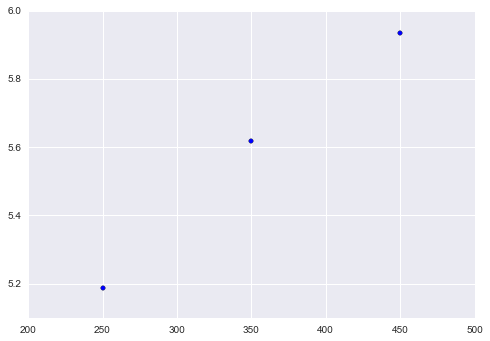

In [38]:
n_clusters, var_ratios = cls_variance_pretty(word_cls_variances)
plt.scatter(n_clusters,var_ratios)

In [39]:
print(np.array(n_clusters)[np.argsort(var_ratios)[::-1]])

[450 350 250]


In [33]:
id2vec = {value.index:key for key, value in model.vocab.iteritems()}

In [34]:
def words_in_cluster(assignments, id2vec):
    """Return a list of all the words in each cluster.
    
    Parameters
    -----------
    assignments : numpy.ndarray
        A vector of the cluster assignment for each word.
    id2vec : mapping
        A mapping from integer ids to words.
        
    Returns
    ---------
    :mapping (id->[words])
        A list where each element is a list of all the words belonging to that particular cluster.
    """
    
    idx = np.arange(0, len(assignments),1)
    return {cls:[id2vec[int(word_idx)] for word_idx in idx[assignments==cls]] for cls in np.unique(assignments)}

In [79]:
cluster250 = words_in_cluster(word_cls_dict[250],id2vec)
cluster250_lengths = {key:len(value) for key, value in cluster250.iteritems()}
sorted(cluster250_lengths.iteritems(), key=lambda (key,value): value)

[(180, 3),
 (245, 3),
 (87, 4),
 (88, 4),
 (100, 4),
 (106, 4),
 (126, 4),
 (130, 4),
 (131, 4),
 (140, 4),
 (143, 4),
 (144, 4),
 (146, 4),
 (149, 4),
 (150, 4),
 (151, 4),
 (152, 4),
 (155, 4),
 (156, 4),
 (157, 4),
 (159, 4),
 (161, 4),
 (175, 4),
 (177, 4),
 (178, 4),
 (179, 4),
 (182, 4),
 (186, 4),
 (193, 4),
 (195, 4),
 (200, 4),
 (201, 4),
 (202, 4),
 (204, 4),
 (216, 4),
 (224, 4),
 (225, 4),
 (227, 4),
 (230, 4),
 (231, 4),
 (232, 4),
 (234, 4),
 (236, 4),
 (238, 4),
 (242, 4),
 (244, 4),
 (246, 4),
 (66, 5),
 (81, 5),
 (90, 5),
 (107, 5),
 (120, 5),
 (129, 5),
 (132, 5),
 (134, 5),
 (137, 5),
 (153, 5),
 (163, 5),
 (164, 5),
 (169, 5),
 (181, 5),
 (191, 5),
 (197, 5),
 (203, 5),
 (205, 5),
 (206, 5),
 (209, 5),
 (211, 5),
 (212, 5),
 (219, 5),
 (221, 5),
 (222, 5),
 (247, 5),
 (249, 5),
 (39, 6),
 (50, 6),
 (62, 6),
 (67, 6),
 (74, 6),
 (104, 6),
 (122, 6),
 (127, 6),
 (133, 6),
 (135, 6),
 (138, 6),
 (139, 6),
 (141, 6),
 (147, 6),
 (158, 6),
 (162, 6),
 (167, 6),
 (192, 6)

Unfortunately, it looks like a lot of the words still fall into a few clusters. Cluster size probably needs to be increased. Or perhaps decreased?

In [80]:
cluster250[110]

[u'examining',
 u'noninvasive',
 u'axonopathy',
 u'primer',
 u'eIF',
 u'hosts',
 u'compaction',
 u'nomenclature',
 u'occasional',
 u'histochemistry',
 u'KmH',
 u'phospho',
 u'coactivation',
 u'sickness',
 u'shRNAs',
 u'characteristically',
 u'coarse',
 u'BBS',
 u'methylglutaryl',
 u'causally']

#### Searching the corpus for words
I'm first going to modify `corpus_iterable_strings` so that it contains the actual bow that went into the doc2vec model. Then, the goal is to find a word cluster whose document-word distribution is dominated by one document cluster.

In [35]:
for idx, document in enumerate(corpus):
    corpus_iterable_strings[idx]['bow'] = set(document.words)
    corpus_iterable_strings[idx]['tag'] = idx
    corpus_iterable_strings[idx]['oldtitle'] = raw_corpus[idx]['title']

In [104]:
document_lookup_df = pd.DataFrame.from_dict(copy.copy(corpus_iterable_strings))

In [105]:
document_lookup_df = document_lookup_df.drop(['mesh_terms','abstract','bow','title'],axis=1)

In [106]:
document_lookup_df.head()

,oldtitle,pmid,tag
0,Early onset cerebellar ataxia with retained te...,1884166,0
1,[Friedreich's ataxia and hereditary vitamin E ...,9773063,1
2,Lipids and lipoproteins in Friedreich's ataxia.,7359148,2
3,Phosphorylation and DNA binding of the regulat...,15073297,3
4,An open-label trial in Friedreich ataxia sugge...,25845763,4


In [31]:
def documents_containing_words(words=None, corpus=None, field='bow',vocab=None):
    """Look up the documents which contain a given list of words.
    
    Parameters
    -----------
    words : set
        A set of words that should be looked up.
    corpus : iterable with fields
        An iterable with a field that contains a bow as a set.
    field : 
        The key for the field to be used in the corpus.
    vocab : mapping[str]->int
        A lookup table from strings to integer ids to be placed into the table.
    
    Returns
    ----------
    doc_word_lookup:numpy.ndarray
        An n_documents x n_words lookup table with the bits set for each word that occured in the document.
    """
    doc_word_lookup = np.zeros((len(corpus),len(vocab)))
    for document in corpus:
        intersection = set.intersection(words,document['bow'])
        if intersection:
            idx_to_set = [vocab[word].index for word in intersection]
            doc_word_lookup[document['tag'],idx_to_set] = 1
        else:
            continue
    
    return doc_word_lookup

In [181]:
dword_table = documents_containing_words(words=set(cluster250[110]),corpus=corpus_iterable_strings,vocab=model.vocab)

By looking at all the nonzero rows in the lookup table, it is possible to figure out which documents contained the words in question and use that as an index into the assignments table to get the cluster representation.

In [199]:
def calc_cls_dist(cls_id_raw):
    distribution = pd.Series(cls_id_raw).value_counts()
    distribution = distribution.sort_index()/np.sum(distribution)
    return distribution

In [254]:
word_cls_focus = words_in_cluster(word_cls_dict[450],id2vec)
sparse_dword_clusters = dict()
for _cls, _words in words_in_cluster(word_cls_dict[450],id2vec).iteritems():
    dword_table = documents_containing_words(words=set(_words), corpus=corpus_iterable_strings,vocab=model.vocab)
    represented_docs, _ = np.nonzero(dword_table)
    dist = calc_cls_dist(cluster_dict[292][represented_docs])
    if np.max(dist)>0.7:
        sparse_dword_clusters[_cls] = represented_docs

In [255]:
print(sparse_dword_clusters.keys())

[424, 338, 207]


In [298]:
W_focus_global = 207

In [299]:
document_lookup_df.iloc[sparse_dword_clusters[W_focus_global]].drop_duplicates(subset='pmid')['oldtitle'].values

array([ u"The incidence and nature of visual pathway involvement in Friedreich's ataxia. A clinical and visual evoked potential study of 22 patients.",
       u'A dictionary model for haplotyping, genotype calling, and association testing.',
       u'FXN methylation predicts expression and clinical outcome in Friedreich ataxia.',
       u"An electroretinal and visual evoked potential study in Friedreich's ataxia.",
       u"Biventricular function in Friedreich's ataxia: a radionuclide angiographic study.",
       u"Biomechanical analysis of simple jaw movements in Friedreich's ataxia.",
       u'[Congestive cardiomyopathy and pyruvate elevation in a case of Charcot-Marie-Tooth disease].',
       u"Friedreich's ataxia, with retained lower limb tendon reflexes, in a Saudi Arabian family.",
       u"A functional MRI study of motor dysfunction in Friedreich's ataxia."], dtype=object)

In [300]:
word_cls_focus[W_focus_global]

[u'premotor', u'interocular', u'radionuclide', u'visits', u'exceptional']

In [301]:
pd.DataFrame.from_dict(list(itertools.chain.from_iterable([raw_corpus[idx]['mesh_terms'] for idx in sparse_dword_clusters[W_focus_global]])))['term'].value_counts()

Friedreich Ataxia                      9
Humans                                 9
Male                                   7
Adult                                  7
Female                                 6
Middle Aged                            4
Child                                  3
Adolescent                             3
Cardiomyopathy, Hypertrophic           2
Reaction Time                          2
Muscular Atrophy                       1
Case-Control Studies                   1
Electromyography                       1
Heart Failure                          1
Evoked Potentials                      1
Functional Laterality                  1
Mutation                               1
Photic Stimulation                     1
Trinucleotide Repeat Expansion         1
Cystic Fibrosis                        1
Evoked Potentials, Visual              1
Cerebellum                             1
Myocardial Contraction                 1
Movement                               1
Reflex, Stretch 

In [294]:
def emphasize_word(abstract_str, wlist):
    fmr_str = '**<span style="color:red">{}</span>**'
    _abstract_str = copy.copy(abstract_str)
    for word in wlist:
        _abstract_str = _abstract_str.replace(word, fmr_str.format(word))
    return _abstract_str

In [304]:
%%asmarkdown
[print(
        emphasize_word(raw_corpus[idx]['title'],word_cls_focus[W_focus_global]),
        '\n\n\n',
        emphasize_word(raw_corpus[idx]['abstract'],word_cls_focus[W_focus_global]),
        '\n',
        ''.join(itertools.repeat('_',300)),
    '\n') for 
 idx in sparse_dword_clusters[W_focus_global]]

## Next Steps
Make a bow for the documents, cluster a bit vector rep of documents. Hierarchial clustering.

1. Try doc2vec, get vector, cluster documents. 
2. Word2vec, sum up all the word vectors for a document, to get a vector for the document, then try clustering that.
3. Picking representative words for each cluster.
4. Random classifier and pick highest coefficent.

#### Baseline clustering using document bow - Hierarchal clustering

In [36]:
#will allow hashing of every document to a fixed-length vector(500)
bit_vec_id2word = gs.corpora.HashDictionary(
    documents=list(itertools.chain.from_iterable([doc['bow'] for doc in corpus_iterable_strings])),
    id_range=D2V_VEC_SIZE,
    debug=False)

In [37]:
bit_vec_corpus = [bit_vec_id2word.doc2bow(doc['bow']) for doc in corpus_iterable_strings]
bit_vec_matrix = scipy.clip(np.matrix(gs.matutils.corpus2dense(bit_vec_corpus,D2V_VEC_SIZE,len(bit_vec_corpus))).T,0,1)
assert((len(bit_vec_corpus),D2V_VEC_SIZE)==bit_vec_matrix.shape)

In [38]:
Z = scipy.cluster.hierarchy.linkage(bit_vec_matrix,'complete',metric='rogerstanimoto')
Z = scipy.clip(Z,0,np.max(Z)) #removing spurious negative values

In [39]:
c, coph_dists = scipy.cluster.hierarchy.cophenet(Z,scipy.spatial.distance.pdist(bit_vec_matrix,metric='rogerstanimoto'))
print(c)

0.547642114055


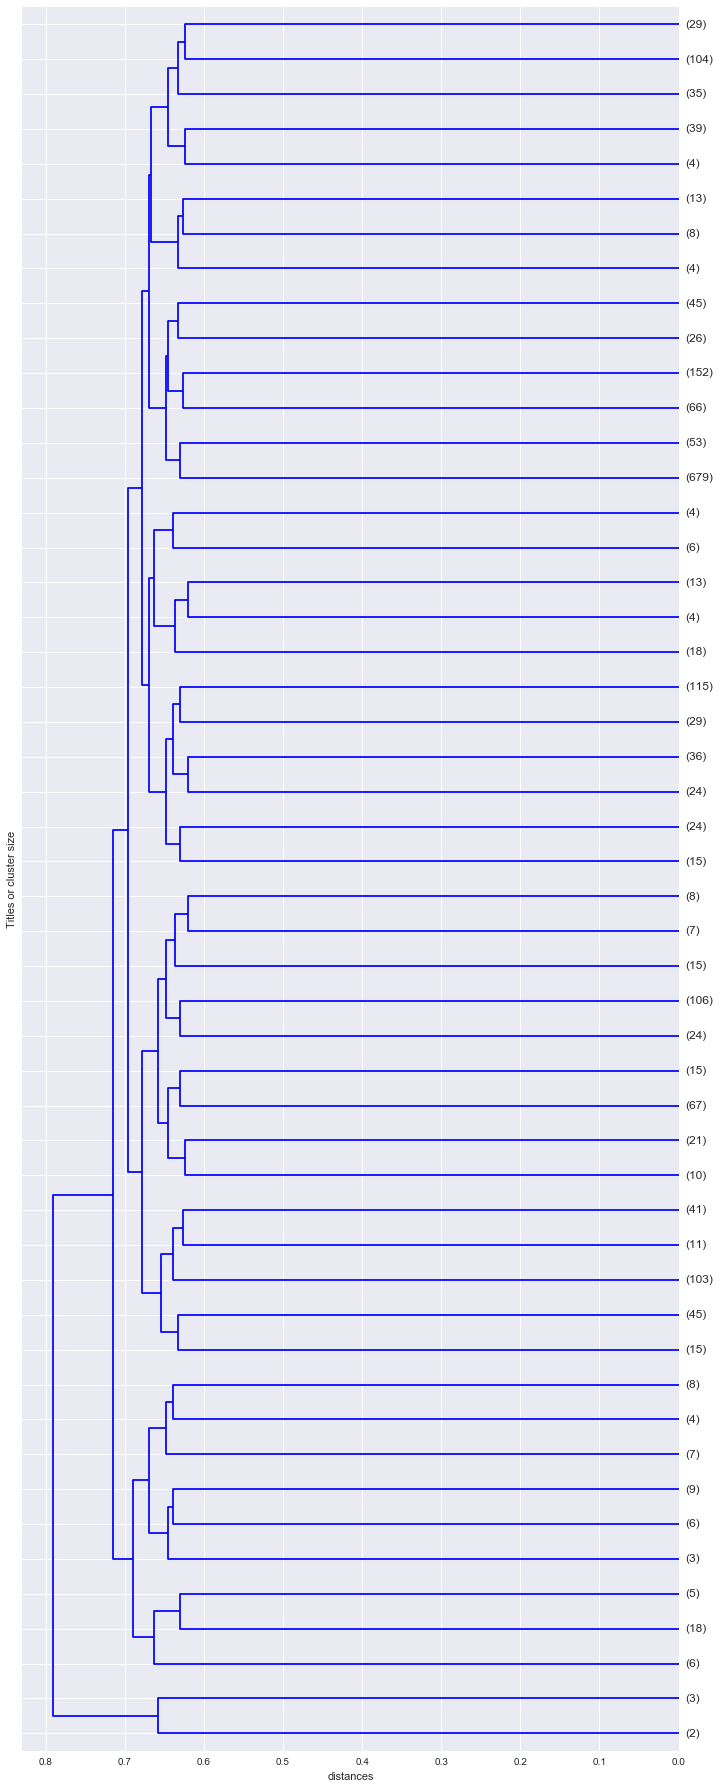

In [40]:
fig = plt.figure(figsize=(10,25))
plt.ylabel('Titles or cluster size')
plt.xlabel('distances')
plt.tight_layout()
scipy.cluster.hierarchy.dendrogram(Z,truncate_mode='lastp',show_leaf_counts='false',
                                   labels=[doc['oldtitle'] for doc in corpus_iterable_strings],
                                  leaf_rotation=0,
                                  orientation='right',
                                  p=50,
                                  leaf_font_size=12)
#plt.xlim(0.7,0.43)
plt.show()

In [41]:
hcluster_ID = scipy.cluster.hierarchy.fcluster(Z,100, criterion='maxclust')
print(len(np.unique(hcluster_ID)))
print(pd.Series(hcluster_ID).value_counts())

94
69    562
68    117
76    107
59     77
91     73
36     67
73     61
42     57
27     47
87     39
71     39
58     38
28     33
24     32
92     31
57     29
74     24
44     24
29     23
81     23
35     21
75     21
56     18
41     18
55     18
32     18
52     17
94     17
40     16
8      16
     ... 
25      5
37      5
63      5
60      5
85      5
6       4
67      4
16      4
13      4
64      4
82      4
86      4
45      3
17      3
10      3
14      3
18      3
22      3
11      3
61      2
3       2
5       2
12      2
7       2
9       2
1       1
19      1
21      1
4       1
2       1
dtype: int64



## Clustering the doc2vec vectors

In [42]:
Z_d2v = scipy.cluster.hierarchy.linkage(features,'complete',metric='cosine')
Z_d2v = scipy.clip(Z_d2v,0,np.max(Z_d2v)) #removing spurious negative values

In [43]:
c_d2v, coph_dists_d2v = scipy.cluster.hierarchy.cophenet(Z_d2v,scipy.spatial.distance.pdist(features,metric='cosine'))
print(c)

0.547642114055


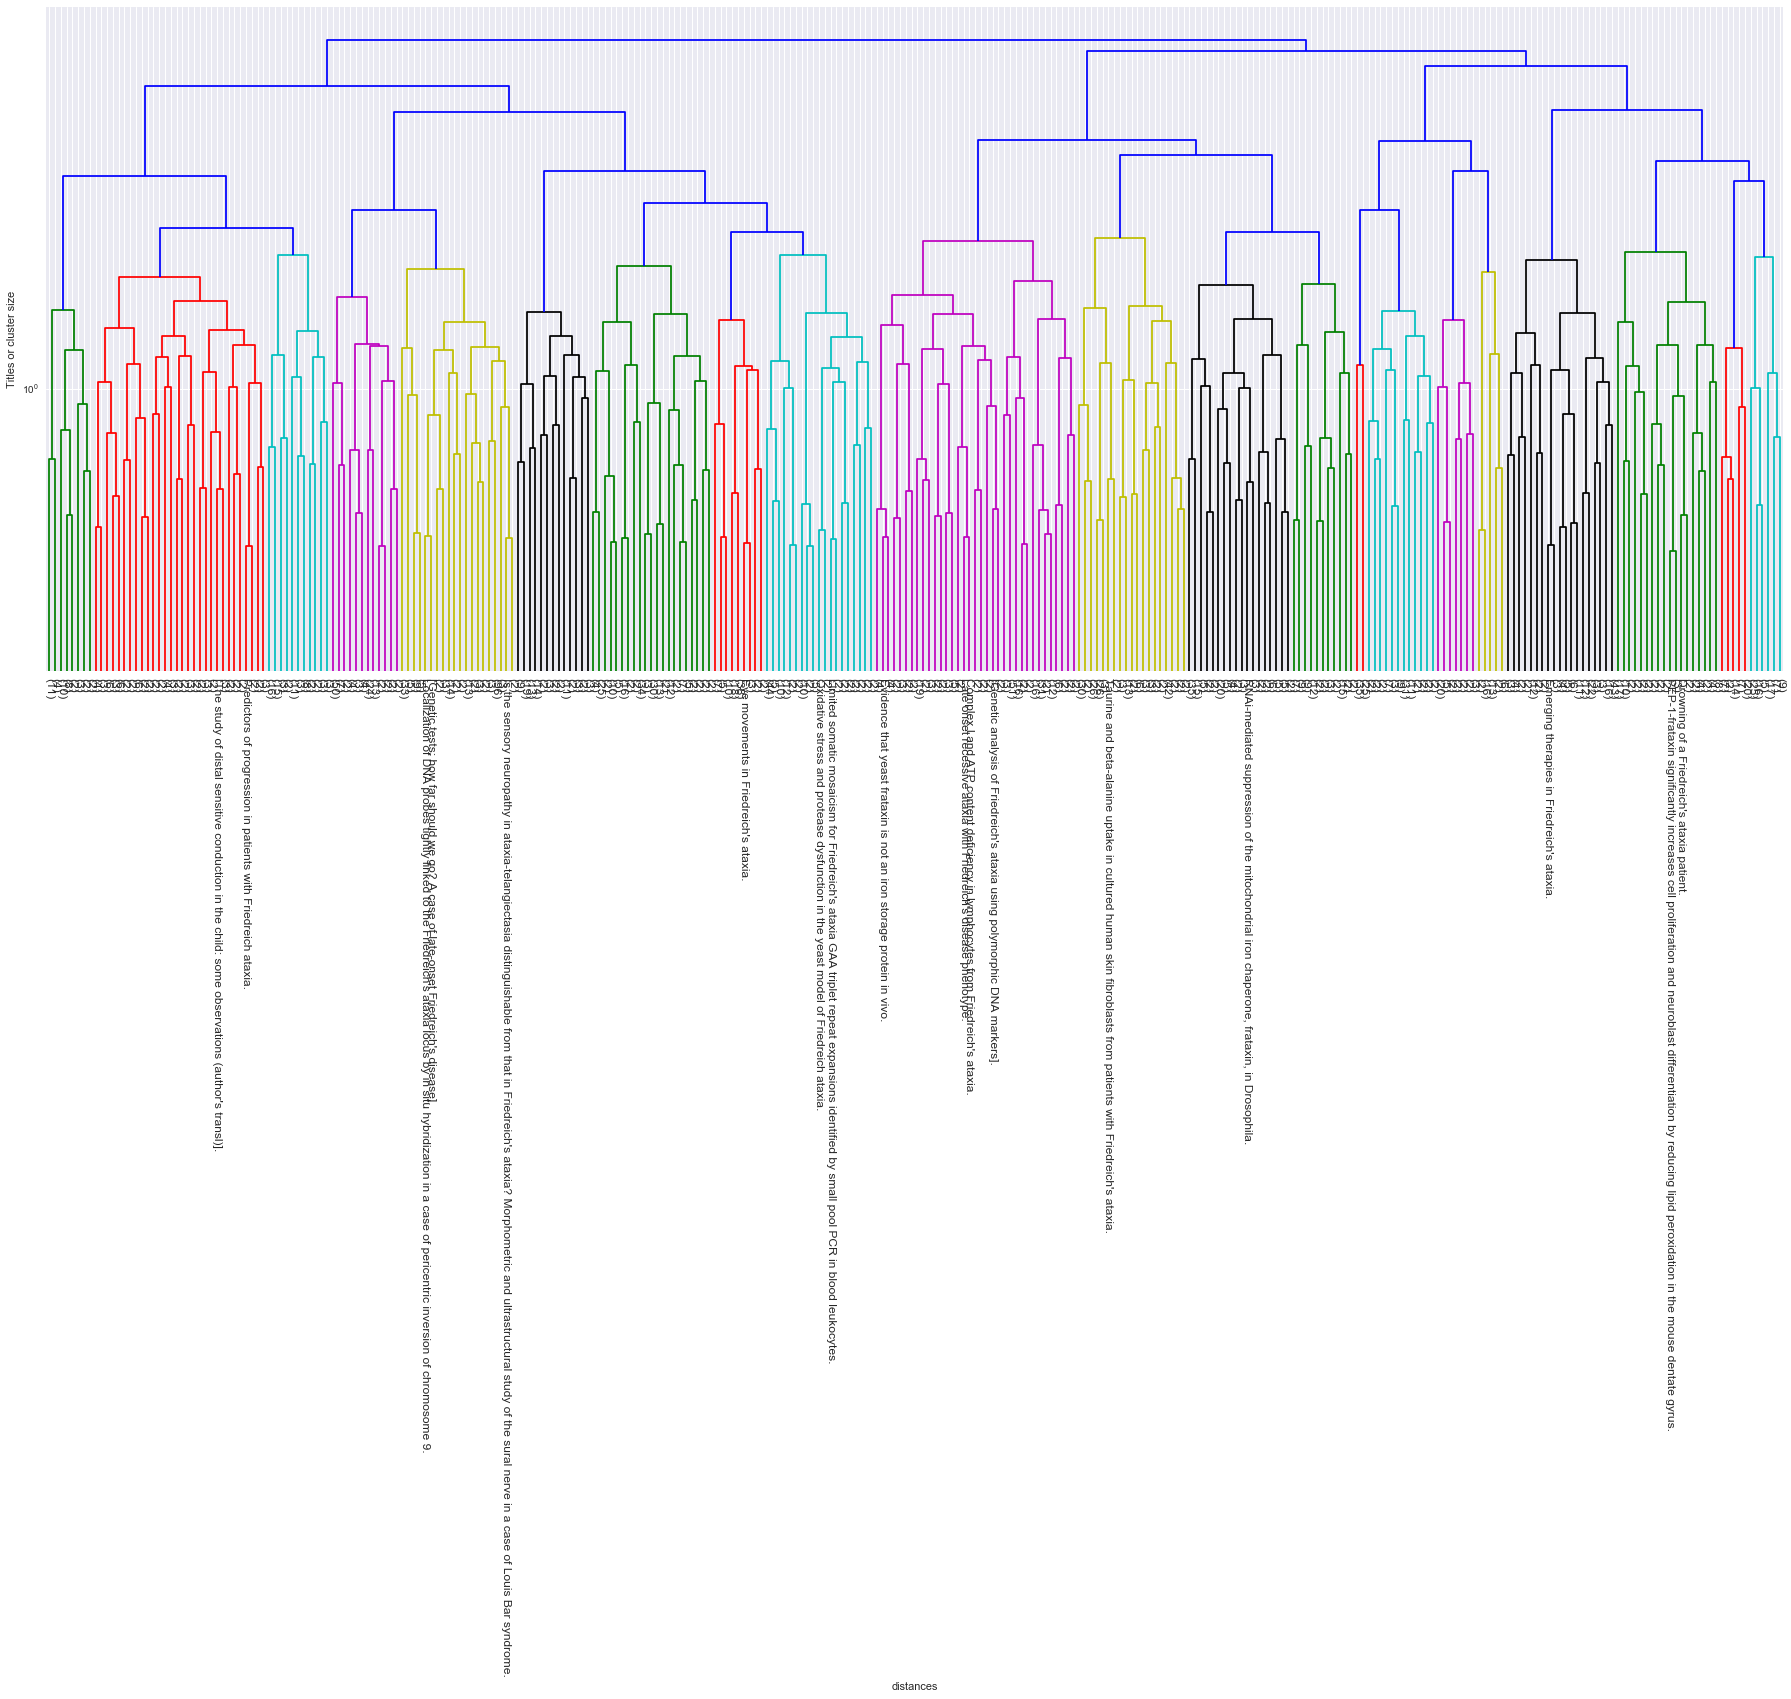

In [44]:
fig = plt.figure(figsize=(25,10))
plt.ylabel('Titles or cluster size')
plt.xlabel('distances')
plt.tight_layout()
scipy.cluster.hierarchy.dendrogram(Z_d2v,truncate_mode='lastp',show_leaf_counts='false',
                                   labels=[doc['oldtitle'] for doc in corpus_iterable_strings],
                                  leaf_rotation=270,
                                  orientation='top',
                                  p=300,
                                  leaf_font_size=12)
plt.ylim(0.8,2.0)
plt.yscale('symlog',basey=10,linthreshy=1.0)
plt.show()

In [45]:
Z_d2v_ID = scipy.cluster.hierarchy.fcluster(Z_d2v,20, criterion='maxclust')
print(len(np.unique(Z_d2v_ID)),'\n____________')
print(pd.Series(Z_d2v_ID).value_counts())

20 
____________
9     214
5     202
8     196
7     182
10    172
17    156
11    119
4     115
6      85
2      81
20     79
14     75
18     68
3      68
12     65
13     60
19     50
1      42
16     39
15     36
dtype: int64


### Making a confusion matrix for word2vec clusters vs bow clusters

The assignments for each are in **`Z_d2v_ID`** and **`hcluster_ID`**.

In [46]:
hcluster_ID_counts = pd.Series(hcluster_ID).value_counts()

In [47]:
hcluster_ID_mask = np.zeros_like(hcluster_ID,dtype=bool)
for accepted_cls_idx in hcluster_ID_counts.index[:4]:
    hcluster_ID_mask[hcluster_ID==accepted_cls_idx] = 1

In [48]:
Z_d2v_ID_counts = pd.Series(Z_d2v_ID).value_counts()
Z_d2v_ID_mask = np.zeros_like(Z_d2v_ID,dtype=bool)
for accepted_cls_idx in Z_d2v_ID_counts.index[:4]:
    Z_d2v_ID_mask[Z_d2v_ID==accepted_cls_idx]=1

In [49]:
_idx = np.indices(Z_d2v_ID_mask.shape)[0]

Computing the indices that both clustering methods share.

In [50]:
shared_idx = set(_idx[hcluster_ID_mask]) & set(_idx[Z_d2v_ID_mask])

In [51]:
shared_mask = np.zeros_like(hcluster_ID_mask,dtype=bool)
shared_mask[list(shared_idx)] = 1

In [52]:
metrics.confusion_matrix(Z_d2v_ID[shared_mask],hcluster_ID[shared_mask])

array([[ 0,  0,  0,  0,  9, 14, 50, 14],
       [ 0,  0,  0,  0,  0, 13, 75,  5],
       [ 0,  0,  0,  0,  1, 16, 66,  9],
       [ 0,  0,  0,  0,  8, 12, 49, 11],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0]])

Renumbering in the assignments in hcluster_ID so the confusion matrix makes more sense.

In [53]:
hcluster_ID_shadow = hcluster_ID.copy()
hcluster_ID_shadow[:] = -1
hcluster_ID_shadow[shared_mask] = hcluster_ID[shared_mask]

In [54]:
hcluster_idx_to_zd2v_idx = collections.defaultdict(lambda : -1)
hcluster_idx_to_zd2v_idx.update({old_id:new_id for old_id, new_id in 
                                 zip(hcluster_ID_counts.index[:4],Z_d2v_ID_counts.index[:4])})

In [55]:
for idx, val in enumerate(hcluster_ID_shadow):
    hcluster_ID_shadow[idx] = hcluster_idx_to_zd2v_idx[val]

In [56]:
metrics.confusion_matrix(Z_d2v_ID[shared_mask],hcluster_ID_shadow[shared_mask])

array([[14,  9, 14, 50],
       [13,  0,  5, 75],
       [16,  1,  9, 66],
       [12,  8, 11, 49]])

In [57]:
cnf_mat = metrics.confusion_matrix(Z_d2v_ID[shared_mask],hcluster_ID_shadow[shared_mask])
pd.DataFrame(cnf_mat, columns='1 2 3 4'.split(), index=[1,2,3,4])

,1,2,3,4
1,14,9,14,50
2,13,0,5,75
3,16,1,9,66
4,12,8,11,49


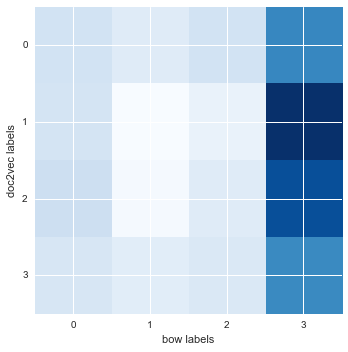

In [58]:
plt.imshow(cnf_mat, interpolation='nearest',cmap=plt.cm.Blues)
plt.xticks([0,1,2,3])
plt.yticks([3,2,1,0])
plt.ylabel('doc2vec labels')
plt.xlabel('bow labels')

## Finding Representative Words for Each Cluster
1. Use a classifier to find the most discriminative words for each cluster.
2. ????
3. Profit

Issues:
Will have to train multi-class classifiers, pipelines, etc.

Features: `features`.

True Y: `Z_d2v_ID`.

In [59]:
sfold_cv = cross_validation.StratifiedKFold(Z_d2v_ID,n_folds=4)

Simple pipeline:
 1. Stratified CV
 2. Features should be the bow for each doc.
 3. Store the features for the corpus as a sparse matrix. 
 4. Choose the words which have the highest coefficient/discriminative ability for each class.

In [60]:
def custom_auc_scorer(estimator, X, y):
    pred = estimator.predict_log_proba(X)
    return metrics.roc_auc_score(y,pred[:,1]-pred[:,0])

In [62]:
bow_corpus= [ ]
for idx, _document in enumerate(corpus_iterable_strings):
    document = drop_stopwords(standardize_words(_document, keys=keys),keys=keys, stopset=stopset)
    bow_corpus.append(document['abstract']+document['title'])

In [63]:
id2word = gs.corpora.Dictionary(bow_corpus)

In [64]:
id2word.filter_extremes(5,0.7)

In [65]:
sparse_corpus = gs.matutils.corpus2csc([id2word.doc2bow(doc) for doc in bow_corpus],num_terms=len(id2word),
                                       num_docs=len(bow_corpus)).T

In [46]:
clf_search = grid_search.RandomizedSearchCV(ensemble.RandomForestClassifier(),
                              {'min_weight_fraction_leaf':list(np.arange(0.1,0.5,0.1)),
                              'max_depth':scipy.stats.distributions.randint(3,50),
                              'min_samples_leaf':scipy.stats.distributions.randint(1,10),
                              'min_samples_split':scipy.stats.distributions.randint(1,10),
                              'n_estimators':scipy.stats.distributions.randint(5,50)},
                              cv=None,
                              n_jobs=2,
                              random_state=np.random.RandomState(seed=0),
                              n_iter=100,
                                           scoring=custom_auc_scorer)

In [47]:
def one_vs_rest_clf(X, y):
    class_performance_dict = dict()
    for label in np.unique(y):
        clf_search = grid_search.RandomizedSearchCV(ensemble.RandomForestClassifier(),
                              {'min_weight_fraction_leaf':list(np.arange(0.1,0.5,0.1)),
                              'max_depth':scipy.stats.distributions.randint(3,50),
                              'min_samples_leaf':scipy.stats.distributions.randint(1,10),
                              'min_samples_split':scipy.stats.distributions.randint(1,10),
                              'n_estimators':scipy.stats.distributions.randint(5,50)},
                              cv=None,
                              n_jobs=2,
                              random_state=np.random.RandomState(seed=0),
                              n_iter=100,
                                                    scoring=custom_auc_scorer)
        y_binary = np.zeros_like(y)
        y_binary[y==label]=1
        clf_search.fit(X,y_binary)
        class_performance_dict[label] = clf_search
    return class_performance_dict

In [48]:
class_perfomance_dict = one_vs_rest_clf(sparse_corpus, Z_d2v_ID)

In [49]:
for cls, estimator in class_perfomance_dict.iteritems():
    imps = estimator.best_estimator_.feature_importances_
    print('|'.join(id2word[x] for x in np.argsort(imps)[-6:]))
    print('-----------------------------------------------------\n')

patients|specific|expression|frataxin|protein|iron
-----------------------------------------------------

group|model|involved|mutation|protein|frataxin
-----------------------------------------------------

model|patients|activity|involved|clinical|mitochondrial
-----------------------------------------------------

medial|owing|challenges|counteract|liver|protein
-----------------------------------------------------

FRDA|expansion|cluster|FA|levels|decreased
-----------------------------------------------------

deficiency|GAA|human|onset|levels|patients
-----------------------------------------------------

proteins|involved|role|gene|neurodegenerative|protein
-----------------------------------------------------

significant|onset|results|patients|frataxin|mitochondrial
-----------------------------------------------------

oxidative|cell|results|found|clinical|iron
-----------------------------------------------------

neurodegenerative|recessive|mitochondrial|clinical|protein|GA

In [50]:
%%script false
class_perfomance_dict = dict()
for label in np.unique(Z_d2v_ID):
    _binary_y = np.zeros_like(Z_d2v_ID)
    _binary_y[Z_d2v_ID==label] = 1
    clf = naive_bayes.MultinomialNB(alpha=0.05,fit_prior=False)
    clf.fit(sparse_corpus, Z_d2v_ID)
    class_perfomance_dict[label] = clf, _binary_y

### Next - Next Steps

1. Try unsupervised random forests and look at the most important words for each cluster.
2. Cluster a bow with each word replaced by a codebook from a word clustering.

Reclustering the words - hierarchal clustering.

Extracting the correct words from the word features and the id2word

In [66]:
id2word_w2v_intersection = set(id2word.values()) & set(model.vocab.keys())
assert(len(id2word_w2v_intersection)==len(id2word))

In [67]:
syn0_reduction_mask = [model.vocab[word].index for word in id2word.values()]
word_features_reduced = word_features[syn0_reduction_mask,:]

In [68]:
#rearranging the rows of the matrix to correspond to the id2word ordering instead of the model.vocab
_,word_features_reduced_remap = zip(*sorted([(model.vocab[word].index,word_id) for word_id,word in id2word.iteritems()],
                                    key=lambda tup: tup[0]))
word_features_reduced = word_features_reduced[word_features_reduced_remap,:]

In [69]:
Z_w2v = scipy.cluster.hierarchy.linkage(word_features_reduced,'complete',metric='cosine')
Z_w2v = scipy.clip(Z_w2v,0,np.max(Z_w2v)) #removing spurious negative values

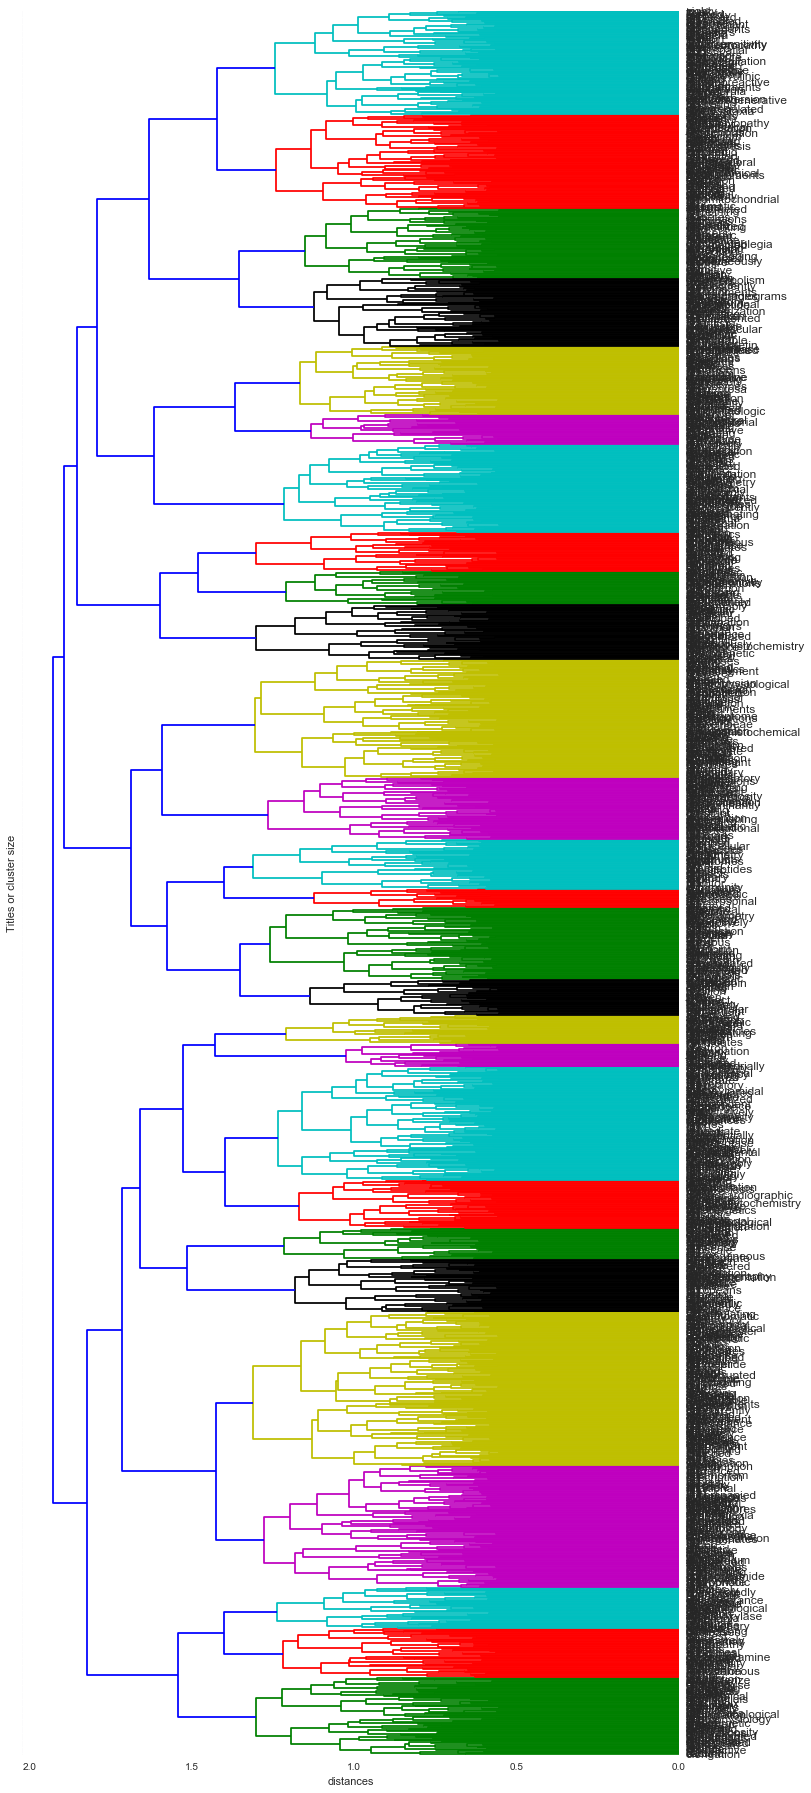

In [70]:
fig = plt.figure(figsize=(10,25))
plt.ylabel('Titles or cluster size')
plt.xlabel('distances')
plt.tight_layout()
scipy.cluster.hierarchy.dendrogram(Z_w2v,truncate_mode='lastp',show_leaf_counts='false',
                                   labels=[id2word[x] for x in range(len(id2word))],
                                  leaf_rotation=0,
                                  orientation='right',
                                  p=2000,
                                  leaf_font_size=12)
#plt.xlim(1.7,1.1)
plt.show()

In [71]:
n_word_clusters = 2000
Z_w2v_ID = scipy.cluster.hierarchy.fcluster(Z_w2v,n_word_clusters, criterion='maxclust')
Z_w2v_ID -= 1 #to do zero based numbering
print(len(np.unique(Z_w2v_ID)),'\n____________')
print(pd.Series(Z_w2v_ID).value_counts())

2000 
____________
496     36
1902    35
763     33
1924    31
342     28
1041    27
324     26
195     25
439     25
1951    24
391     24
378     24
1640    23
979     22
999     21
1893    21
1983    21
772     21
891     21
1963    21
1078    20
1183    19
207     19
300     19
1904    19
473     19
208     19
328     19
1856    18
857     18
        ..
1130     1
1138     1
1142     1
1030     1
1026     1
1022     1
938      1
890      1
894      1
898      1
902      1
906      1
910      1
918      1
922      1
926      1
930      1
942      1
1014     1
946      1
950      1
962      1
966      1
970      1
974      1
982      1
986      1
994      1
1006     1
0        1
dtype: int64


In [73]:
id2cls = {w_id:Z_w2v_ID[w_id] for w_id in id2word.keys()}

The older bow stuff can now be reduced since each bow can be replaced with its cluster assignments.

In [74]:
def unroll_document(document):
        flat_doc = itertools.chain.from_iterable([itertools.repeat(word_id,repeats) for word_id, repeats in document])
        return flat_doc

def reroll_document_w_map(flat_document, remap=None):
    rerolled_document = []
    for w_id, grp in itertools.groupby([remap[old_w_id] for old_w_id in flat_document]):
        rerolled_document.append((w_id, len(list(grp))))
    return rerolled_document

In [75]:
cls_codebook_corpus = []
for document in [id2word.doc2bow(doc) for doc in bow_corpus]:
    cls_codebook_corpus.append(reroll_document_w_map(unroll_document(document),remap=id2cls))

In [76]:
cls_codebook_sparse_corpus = gs.matutils.corpus2dense(cls_codebook_corpus,
                                                   num_terms=n_word_clusters,
                                                   num_docs=len(cls_codebook_corpus)).T

At this point, each of the individual words have been removed and replaced with their corresponding codebook entry. Classification can proceed as normal, with the the target being the previous `Z_d2v_ID`. Accuracies can be compared to see how much the performance degrades.

In [77]:
#old_accuracy
for cls, estimator in class_perfomance_dict.iteritems():
    print('{cls}:{score}'.format(cls=cls,score=estimator.best_score_))

NameError: name 'class_perfomance_dict' is not defined

In [107]:
class_perfomance_codebook_dict = one_vs_rest_clf(cls_codebook_sparse_corpus, Z_d2v_ID)

In [108]:
for cls, estimator in class_perfomance_codebook_dict.iteritems():
    print('{cls}:{score}'.format(cls=cls,score=estimator.best_score_))

1:0.637289441841
2:0.638990872934
3:0.750399402803
4:0.515006947062
5:0.652525034688
6:0.593663457083
7:0.706861090635
8:0.701195893447
9:0.750783733829
10:0.831323606847
11:0.808401665979
12:0.703342229634
13:0.660751852841
14:0.633453653615
15:0.698915971659
16:0.870514042309
17:0.767386514693


In [109]:
bow_clf_accuracy = np.mean([estimator.best_score_ for estimator in class_perfomance_dict.itervalues()])
codebook_clf_accuracy = np.mean([estimator.best_score_ for estimator in class_perfomance_codebook_dict.itervalues()])
print('bow_accuracy:{bow}\ncodebook_accuracy:{cb}'.format(bow=bow_clf_accuracy, cb=codebook_clf_accuracy))

bow_accuracy:0.759693439611
codebook_accuracy:0.701223847759


In [124]:
def _get_cluster_dmatrix(cls_id, word_features_X=None, word_cls_assignments=None):
    """Calculate the distance of all words in a cluster from the average word.
    
    Parameters
    -----------
    cls_id : int
        The cluster to examine.
    word_features_x : numpy.ndarray
        An n_words x n_features array out of the doc2vec or word2vec model.
    word_cls_assignments : numpy.ndarray
        An n_samples array which holds the cluster assignment for each word.
    
    Returns
    --------
    distance_matrix : numpy.ndarray
        An n_samples distance matrix, unsorted.
    """
    w_mean = np.mean(word_features_X[word_cls_assignments==cls_id],axis=0)
    distance_matrix = scipy.spatial.distance.cdist(w_mean,word_features_X)
    return distance_matrix

In [158]:
def get_representative_words_for_each_cluster(n_clusters=50,
                                              word_features_X=None,
                                              word_cls_assignments=None,
                                              id2word=None):
    #TODO: Docstring this up fam
    cls_representatives = dict()
    for cls_id in range(n_clusters):
        dmatrix = _get_cluster_dmatrix(cls_id, word_features_X=word_features_X, 
                                       word_cls_assignments=word_cls_assignments).ravel()
        cls_representatives[cls_id] = [id2word[like_word] for like_word in np.argsort(dmatrix)[:3]]
    return cls_representatives

In [159]:
cls_representatives = get_representative_words_for_each_cluster(n_clusters=n_word_clusters,
                                                               word_features_X=word_features_reduced,
                                                               word_cls_assignments=Z_w2v_ID,
                                                               id2word=id2word)

In [162]:
for cls, estimator in class_perfomance_codebook_dict.iteritems():
    imps = np.argsort(estimator.best_estimator_.feature_importances_)[-5:]
    wdf = pd.DataFrame.from_dict(data={cls_id:cls_representatives[cls_id] for cls_id in imps})
    display(HTML(wdf.to_html(columns=wdf.columns)))
    imps = class_perfomance_dict[cls].best_estimator_.feature_importances_
    print('|'.join(id2word[x] for x in np.argsort(imps)[-5:]))
    print('-----------------------------------------------------\n')

,16,18,26,38,41
0,melanogaster,ability,ancient,overexpressed,nucleic
1,prenatal,ambulant,subclinical,daughter,vicinity
2,collection,output,pointed,expression,interacting


specific|expression|frataxin|protein|iron
-----------------------------------------------------



,3,10,12,39,43
0,contraction,analogs,minority,strictly,day
1,preceding,subunits,adenosine,diffusivity,characterisation
2,deformities,learning,document,finding,aging


model|involved|mutation|protein|frataxin
-----------------------------------------------------



,3,17,38,39,41
0,contraction,producing,overexpressed,strictly,nucleic
1,preceding,reflect,daughter,diffusivity,vicinity
2,deformities,structure,expression,finding,interacting


patients|activity|involved|clinical|mitochondrial
-----------------------------------------------------



,3,4,38,41,42
0,contraction,fitness,overexpressed,nucleic,electro
1,preceding,canadian,daughter,vicinity,undetermined
2,deformities,lethargy,expression,interacting,uniformly


owing|challenges|counteract|liver|protein
-----------------------------------------------------



,1,3,38,41,48
0,feature,contraction,overexpressed,nucleic,clear
1,underwent,preceding,daughter,vicinity,arginine
2,h,deformities,expression,interacting,concentrations


expansion|cluster|FA|levels|decreased
-----------------------------------------------------



,3,18,23,38,42
0,contraction,ability,interferes,overexpressed,electro
1,preceding,ambulant,polymorphisms,daughter,undetermined
2,deformities,output,mtDNA,expression,uniformly


GAA|human|onset|levels|patients
-----------------------------------------------------



,3,30,36,38,46
0,contraction,legs,titration,overexpressed,neuronal
1,preceding,ten,arise,daughter,changing
2,deformities,strongly,catalase,expression,eight


involved|role|gene|neurodegenerative|protein
-----------------------------------------------------



,3,30,39,42,46
0,contraction,legs,strictly,electro,neuronal
1,preceding,ten,diffusivity,undetermined,changing
2,deformities,strongly,finding,uniformly,eight


onset|results|patients|frataxin|mitochondrial
-----------------------------------------------------



,2,23,36,40,41
0,arm,interferes,titration,functions,nucleic
1,filtration,polymorphisms,arise,malignant,vicinity
2,ion,mtDNA,catalase,diverse,interacting


cell|results|found|clinical|iron
-----------------------------------------------------



,3,30,36,38,40
0,contraction,legs,titration,overexpressed,functions
1,preceding,ten,arise,daughter,malignant
2,deformities,strongly,catalase,expression,diverse


recessive|mitochondrial|clinical|protein|GAA
-----------------------------------------------------



,14,16,22,27,39
0,fibroblasts,melanogaster,described,basic,strictly
1,elegans,prenatal,high,CyaY,diffusivity
2,viologen,collection,donor,parameters,finding


data|affected|study|analysis|results
-----------------------------------------------------



,18,36,37,40,46
0,ability,titration,glucose,functions,neuronal
1,ambulant,arise,constructed,malignant,changing
2,output,catalase,multiplex,diverse,eight


associated|identified|expansion|iron|findings
-----------------------------------------------------



,3,14,16,36,46
0,contraction,fibroblasts,melanogaster,titration,neuronal
1,preceding,elegans,prenatal,arise,changing
2,deformities,viologen,collection,catalase,eight


three|FRDA|repeat|human|protein
-----------------------------------------------------



,3,23,30,36,46
0,contraction,interferes,legs,titration,neuronal
1,preceding,polymorphisms,ten,arise,changing
2,deformities,mtDNA,strongly,catalase,eight


show|showed|stress|human|iron
-----------------------------------------------------



,18,23,38,39,41
0,ability,interferes,overexpressed,strictly,nucleic
1,ambulant,polymorphisms,daughter,diffusivity,vicinity
2,output,mtDNA,expression,finding,interacting


clinical|intron|also|cell|present
-----------------------------------------------------



,12,14,17,22,44
0,minority,fibroblasts,producing,described,static
1,adenosine,elegans,reflect,high,compensated
2,document,viologen,structure,donor,nascent


iron|within|gene|show|FRDA
-----------------------------------------------------



,12,14,22,27,46
0,minority,fibroblasts,described,basic,neuronal
1,adenosine,elegans,high,CyaY,changing
2,document,viologen,donor,parameters,eight


different|specific|repeat|DNA|mutation
-----------------------------------------------------



### Too Much Compression?
Any clusters with more than ~10 word might not be coherent. Repeat the bow process, but this time only replacing the words which belong to clusters that are acceptable according to our criteria. Dealing with the id2word might be more difficult in this case.

In [78]:
Z_w2v_ID_counts = pd.Series(Z_w2v_ID).value_counts()
print(Z_w2v_ID_counts.head())

496     36
1902    35
763     33
1924    31
342     28
dtype: int64


How many acceptable clusters are there?

In [79]:
np.count_nonzero(np.logical_and(2<=Z_w2v_ID_counts,Z_w2v_ID_counts<=10))

411

Preparing a new id2cls:
```python
id2cls = {w_id:Z_w2v_ID[w_id] for w_id in id2word.keys()} #the old code
```
-------------------------------------------------------------------
I need to prepare a new Z_w2v_ID that can be used to make a id2cls. Replace the ID with the word if the document is not in a list of acceptable clusters, the ID otherwise.

In [80]:
Z_w2v_ID_wreplace = np.zeros_like(Z_w2v_ID) #this will hold the "correct" ids for making the id2cls

In [81]:
#this will be used to index into Z_w2v_ID
acceptable_clusters = Z_w2v_ID_counts.index[np.logical_and(2<=Z_w2v_ID_counts,Z_w2v_ID_counts<=10)]

In [82]:
cls_or_word_disambiguation = dict()
new_word_id_counter = itertools.count(start=np.max(acceptable_clusters.values),step=1)
for idx, cls_id in enumerate(Z_w2v_ID):
    if cls_id in acceptable_clusters:
        Z_w2v_ID_wreplace[idx] = cls_id
    else:
        _new_id = new_word_id_counter.next()
        Z_w2v_ID_wreplace[idx] = _new_id
        cls_or_word_disambiguation[idx] = (id2word[idx], _new_id)

Now the id2cls can be created like before.

In [83]:
id2cls = {w_id:Z_w2v_ID_wreplace[w_id] for w_id in id2word.iterkeys()}

In [84]:
cls_codebook_corpus_wreplace = []
for document in [id2word.doc2bow(doc) for doc in bow_corpus]:
    cls_codebook_corpus_wreplace.append(reroll_document_w_map(unroll_document(document),remap=id2cls))

To convert to a dense matrix, I need to know the number of terms we have left.

In [85]:
n_terms_left_areplace = _new_id+1

In [86]:
cls_codebook_sparse_corpus_wreplace = gs.matutils.corpus2dense(cls_codebook_corpus_wreplace,
                                                   num_terms=n_terms_left_areplace,
                                                   num_docs=len(cls_codebook_corpus_wreplace)).T

In [87]:
cls_codebook_sparse_corpus_wreplace = preprocessing.binarize(cls_codebook_sparse_corpus_wreplace).astype(np.double)

clustering time

In [88]:
Z_d2v_wreplace = scipy.cluster.hierarchy.linkage(cls_codebook_sparse_corpus_wreplace,'complete',metric='rogerstanimoto')
Z_d2v_wreplace = scipy.clip(Z_d2v_wreplace,0,np.max(Z_d2v_wreplace)) #removing spurious negative values

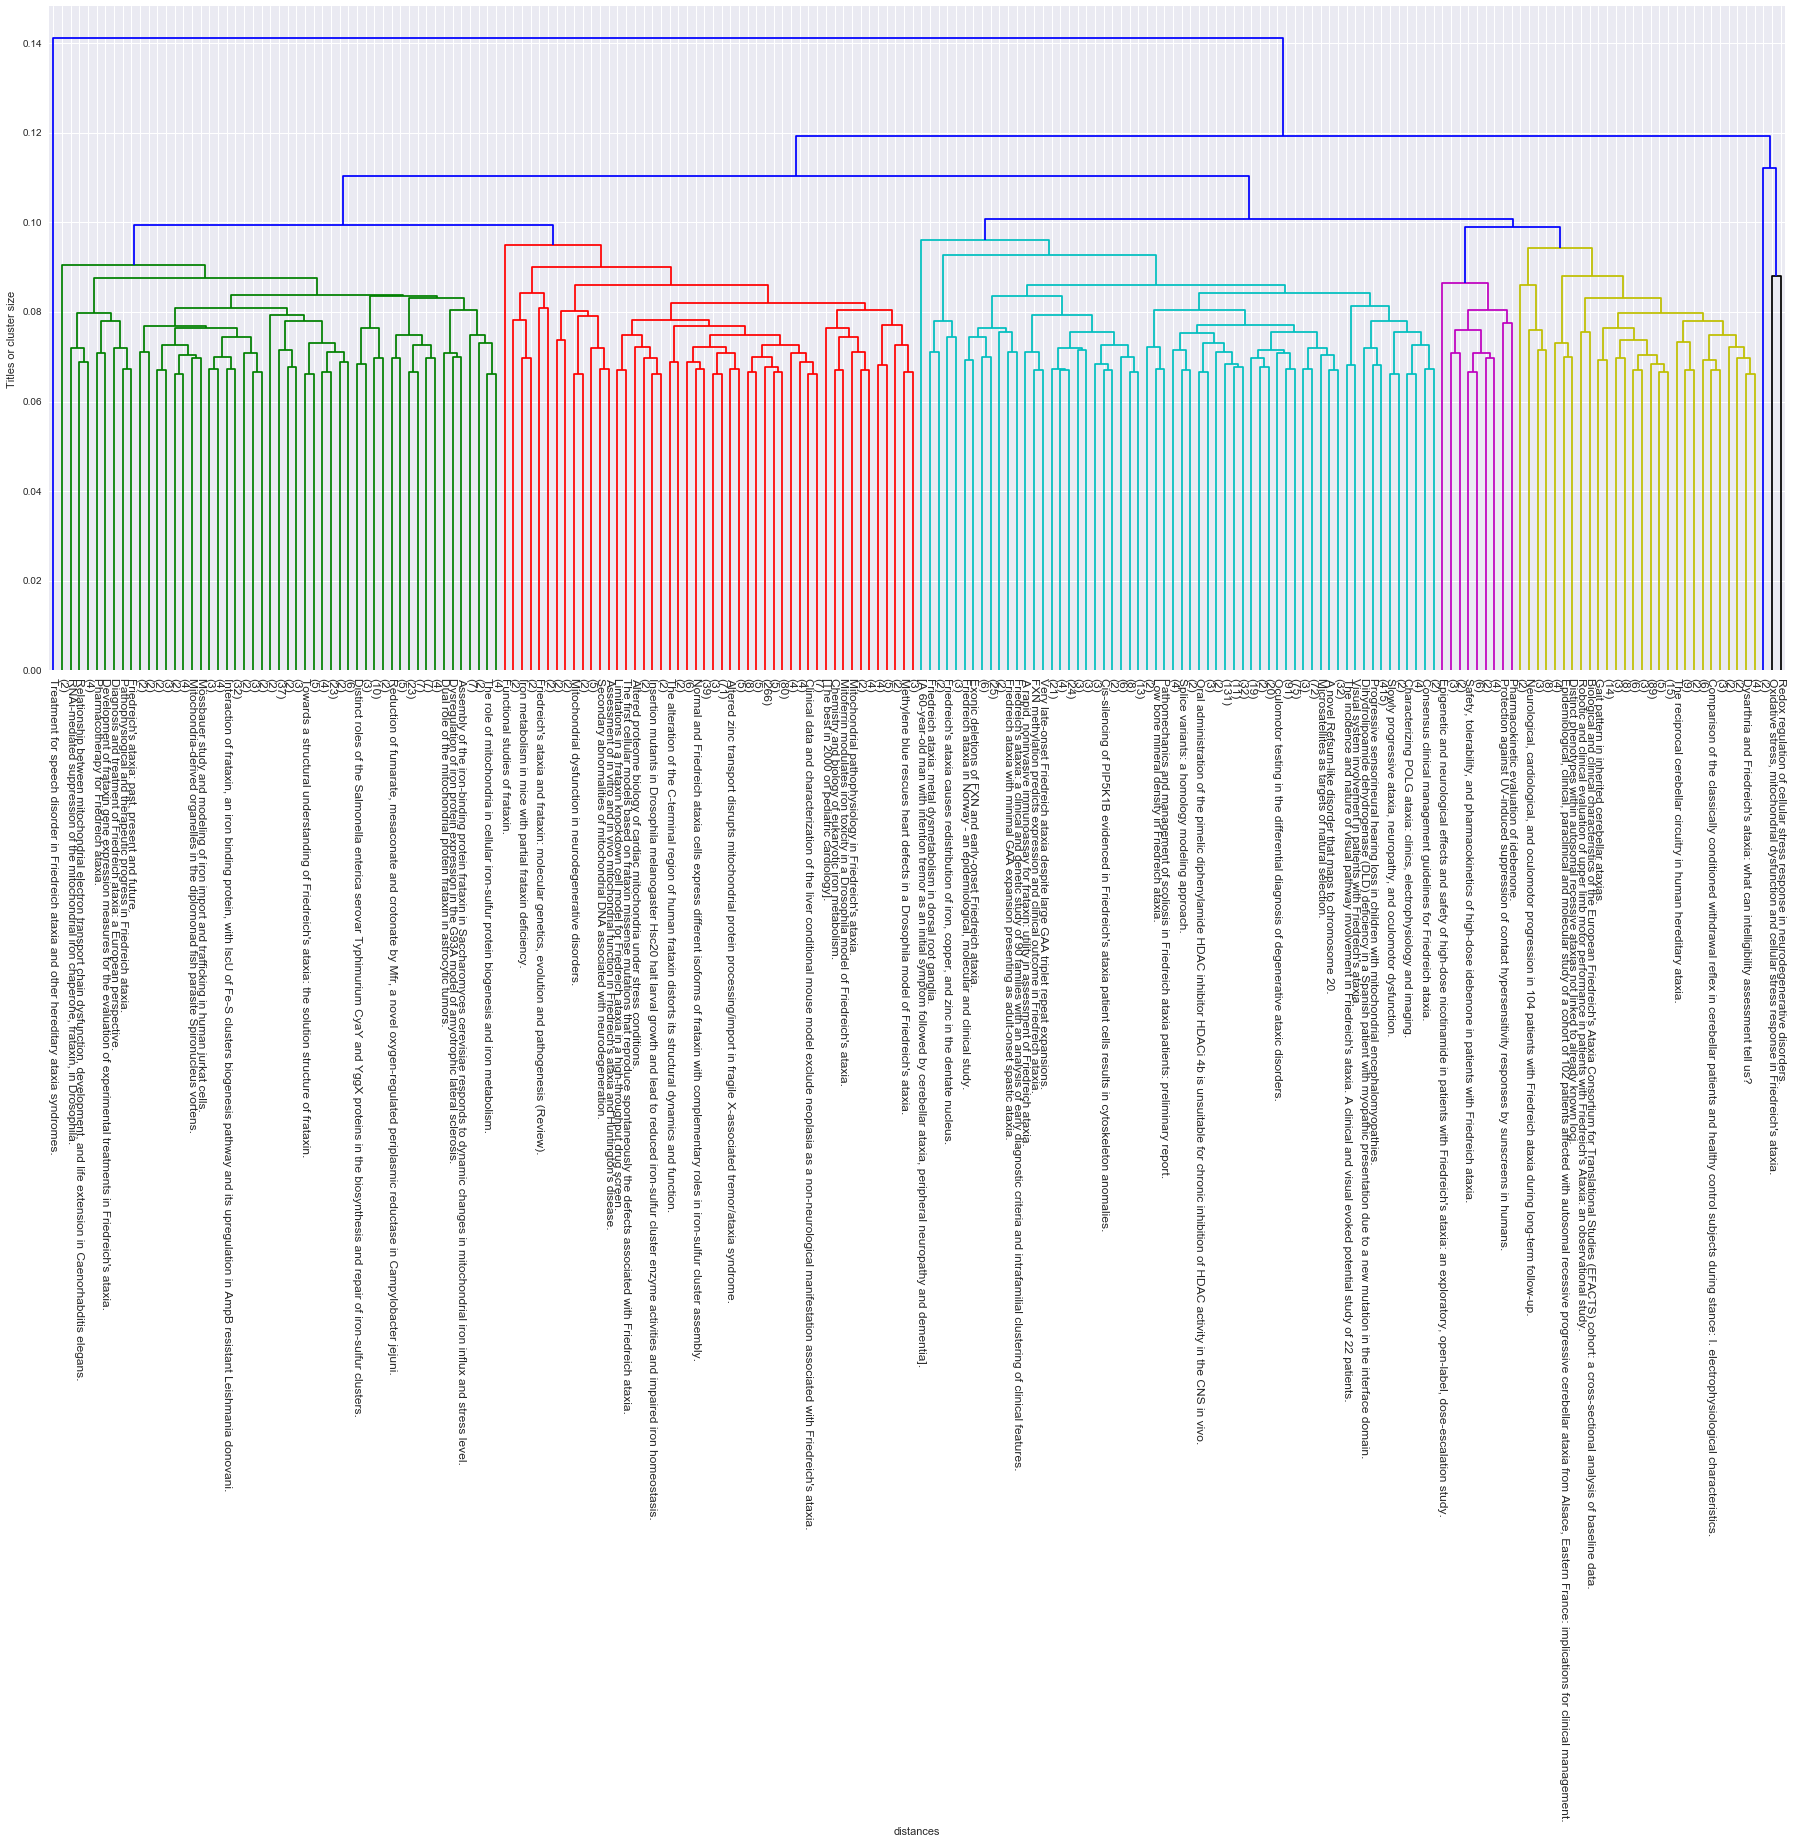

In [89]:
fig = plt.figure(figsize=(25,10))
plt.ylabel('Titles or cluster size')
plt.xlabel('distances')
plt.tight_layout()
scipy.cluster.hierarchy.dendrogram(Z_d2v_wreplace,truncate_mode='lastp',show_leaf_counts='false',
                                   labels=[doc['oldtitle'] for doc in corpus_iterable_strings],
                                  leaf_rotation=270,
                                  orientation='top',
                                  p=200,
                                  leaf_font_size=12)
#plt.xlim(0.12,0.06)
plt.show()

In [90]:
Z_d2v_ID_wreplace = scipy.cluster.hierarchy.fcluster(Z_d2v_wreplace,100, criterion='maxclust')
print(len(np.unique(Z_d2v_ID_wreplace)),'\n____________')
print(pd.Series(Z_d2v_ID_wreplace).value_counts())

99 
____________
70    416
40    364
66    208
65    176
90    118
39     80
67     75
57     49
38     46
13     42
10     40
15     35
68     34
53     31
19     30
60     27
41     16
88     15
77     13
17     12
20     11
82     11
91     11
89     11
93     10
45      9
9       8
11      7
43      7
95      7
     ... 
33      2
69      2
27      2
25      2
23      2
5       2
61      2
81      2
85      2
96      2
94      2
75      1
83      1
71      1
6       1
87      1
79      1
78      1
51      1
28      1
80      1
36      1
44      1
3       1
48      1
97      1
98      1
92      1
86      1
99      1
dtype: int64


### Making a confusion matrix to visualize cluster changes

In [91]:
Z_d2v_ID_wreplace_counts = pd.Series(Z_d2v_ID_wreplace).value_counts()
Z_d2v_ID_counts = pd.Series(Z_d2v_ID).value_counts()

In [92]:
idx = np.arange(0, len(Z_d2v_ID))
_shr_idx1 = set(itertools.chain.from_iterable([idx[Z_d2v_ID_wreplace==_idx] for _idx in Z_d2v_ID_wreplace_counts[:10].index]))
_shr_idx2 = set(itertools.chain.from_iterable([idx[Z_d2v_ID==_idx] for _idx in Z_d2v_ID_counts[:10].index]))
shared_idx = list(_shr_idx1 & _shr_idx2)

In [93]:
def iter_remap_0(in_idx):
    _in_idx = list(in_idx)
    states = np.unique(in_idx)
    transitions = {state:transition for state, transition in zip(states, range(len(states)))}
    return [transitions[elem] for elem in _in_idx]

In [94]:
conf_mat = metrics.confusion_matrix(np.array(iter_remap_0(Z_d2v_ID_wreplace[shared_idx])),
                                  np.array(iter_remap_0(Z_d2v_ID[shared_idx])))

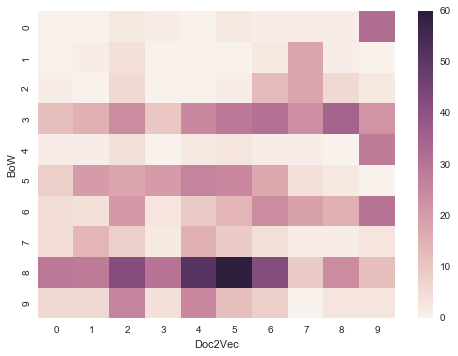

In [95]:
sns.heatmap(conf_mat)
plt.xlabel('Doc2Vec')
plt.ylabel('BoW')

In [96]:
conf_mat

array([[ 0,  0,  2,  1,  0,  2,  1,  1,  1, 32],
       [ 0,  1,  4,  0,  0,  0,  2, 18,  1,  0],
       [ 1,  0,  6,  0,  0,  1, 13, 18,  6,  2],
       [12, 15, 24, 10, 25, 29, 31, 23, 35, 22],
       [ 1,  1,  4,  0,  2,  3,  1,  1,  0, 28],
       [ 8, 20, 18, 20, 26, 25, 17,  4,  2,  0],
       [ 5,  4, 21,  3,  9, 14, 24, 19, 15, 30],
       [ 5, 14,  8,  2, 15,  9,  4,  1,  1,  3],
       [29, 28, 42, 30, 51, 60, 42,  9, 24, 12],
       [ 6,  6, 26,  4, 25, 12,  8,  0,  3,  3]])

In [97]:
def compare_conf_mats(y1,y2,topn=10,all_stats=False):
    assert(len(y1)==len(y2))
    idx =  np.arange(0, len(y1))
    y1_counts = pd.Series(y1).value_counts()
    y2_counts = pd.Series(y2).value_counts()
    _shr_idx1 = set(
        itertools.chain.from_iterable([idx[y1==_idx] for _idx in y1_counts[:topn].index]))
    _shr_idx2 = set(
        itertools.chain.from_iterable([idx[y2==_idx] for _idx in y2_counts[:topn].index]))
    shared_idx = list(_shr_idx1 & _shr_idx2)
    imap1 = iter_remap_0(y1[shared_idx])
    imap2 = iter_remap_0(y2[shared_idx])
    if not all_stats:
        return metrics.confusion_matrix(imap1,imap2)
    elif all_stats:
        return (metrics.confusion_matrix(imap1,imap2), imap1,imap2)

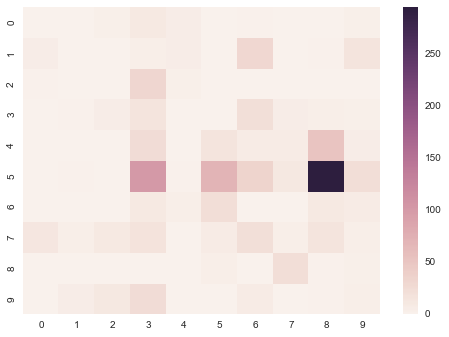

In [98]:
sns.heatmap(compare_conf_mats(hcluster_ID, Z_d2v_ID_wreplace))

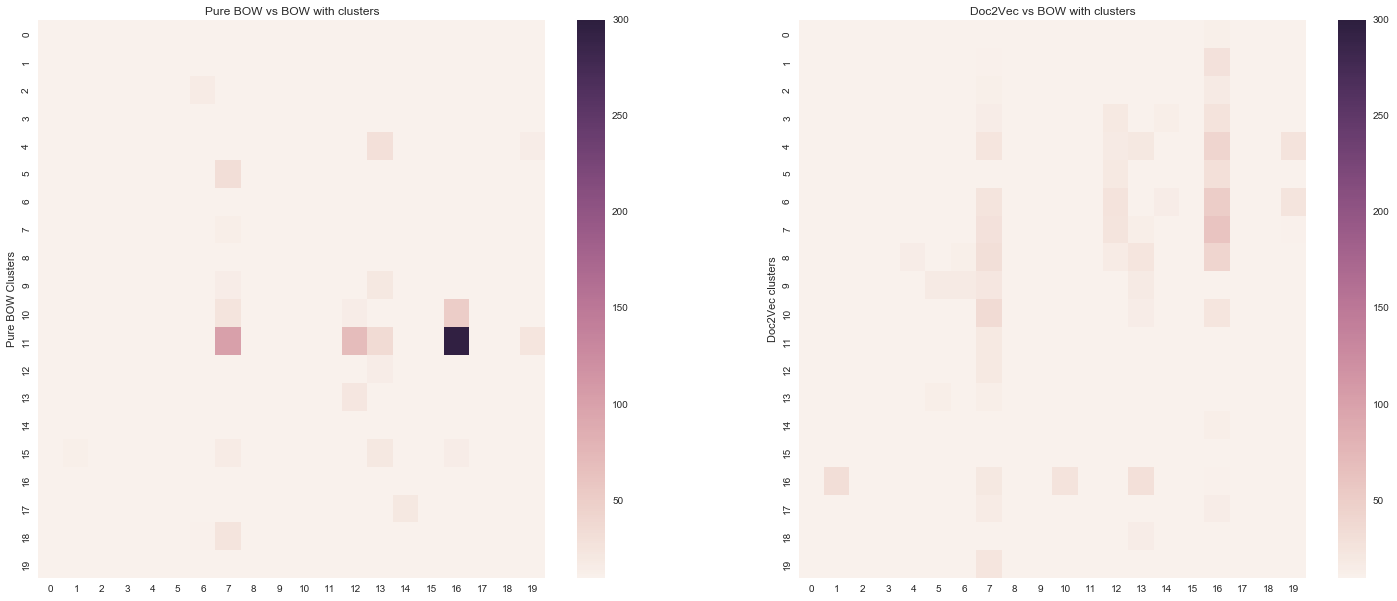

In [99]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(25,10))
sns.heatmap(compare_conf_mats(hcluster_ID,Z_d2v_ID_wreplace,topn=20),ax=ax1,vmin=10,vmax=300)
ax1.set_title('Pure BOW vs BOW with clusters')
ax1.set_ylabel('Pure BOW Clusters')
sns.heatmap(compare_conf_mats(Z_d2v_ID,Z_d2v_ID_wreplace,topn=20),ax=ax2,vmin=10, vmax=300)
ax2.set_title('Doc2Vec vs BOW with clusters')
ax2.set_ylabel('Doc2Vec clusters')
plt.savefig('/Users/kahnza2/Documents/confusion_matrices/clustering_conf.pdf')

In [100]:
def _perc_row_scan(val_count1, val_count2, row=None):
    for idx,elem in enumerate(row):
        v1,v2 = int(val_count1[idx]), int(val_count2[idx])
        perc_base=min(v1,v2)
        if elem>perc_base:
            print(idx, elem, perc_base)
            #raise ValueError
        yield elem/perc_base
        


def conf_mat_percentages(y1,y2,topn=10):
    cf,imap1,imap2 = compare_conf_mats(y1,y2,topn=topn,all_stats=True)
    y1_counts = pd.Series(imap1).value_counts()
    y2_counts = pd.Series(imap2).value_counts()
    perc_cf = []
    for row in range(topn):
        perc_cf.append(list(_perc_row_scan(y1_counts,y2_counts,row=cf[row,:])))
    perc_cf = np.matrix(perc_cf)
    assert(perc_cf.shape==cf.shape)
    return perc_cf

7 32 20
7 25 20
16 51 20
7 102 20
12 71 38
16 295 20
14 22 20
7 25 20


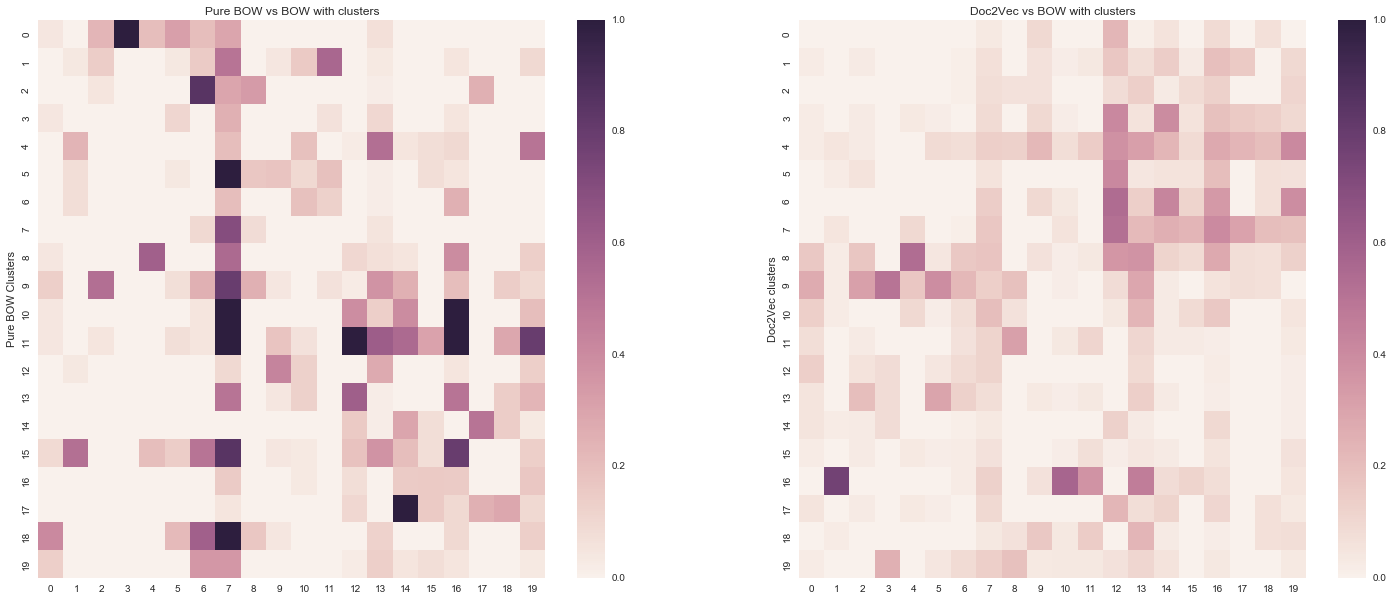

In [101]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(25,10))
sns.heatmap(conf_mat_percentages(hcluster_ID,Z_d2v_ID_wreplace,topn=20),ax=ax1,vmin=0,vmax=1.0)
ax1.set_title('Pure BOW vs BOW with clusters')
ax1.set_ylabel('Pure BOW Clusters')
sns.heatmap(conf_mat_percentages(Z_d2v_ID,Z_d2v_ID_wreplace,topn=20),ax=ax2,vmin=0, vmax=1.0)
ax2.set_title('Doc2Vec vs BOW with clusters')
ax2.set_ylabel('Doc2Vec clusters')
plt.savefig('/Users/kahnza2/Documents/confusion_matrices/clustering_conf.pdf')

### Displaying words in clusters

In [102]:
id2cls_array = np.array([id2cls[x] for x in range(len(id2word))])

In [103]:
id2cls_count = pd.Series(id2cls_array).value_counts()

In [104]:
def sample_groups(ids, sizes=None):
    counts = pd.Series(ids).value_counts()
    for size in sizes:
        acceptable = counts[counts==size]
        yield random.choice(acceptable.index)

In [105]:
print(*[id2word[x] for x in np.nonzero(id2cls_array==1119)[0]])

In [106]:
print(*[id2word[x] for x in np.nonzero(id2cls_array==1181)[0]])

In [107]:
print(*[id2word[x] for x in np.nonzero(id2cls_array==842)[0]])

In [108]:
for size in sample_groups(id2cls_array,sizes=[2,5,10]):
    print(*[id2word[x] for x in np.nonzero(id2cls_array==size)[0]])

datasets proteomic
simultaneously LC ferrous evaluations characteristic
combination inhibit axons article capture includes irrespective addressed examined neisseria


In [151]:
dmatrix_ = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(model.syn0,metric='cosine'))

In [152]:
rows,cols = np.diag_indices_from(dmatrix_)

In [153]:
dmatrix_[rows,cols] = np.inf

In [154]:
model_id2word = {value.index:key for key, value in model.vocab.iteritems()}

In [155]:
closest_words =[]
for row in range(len(id2word)):
    closest_words.append((model_id2word[row], model_id2word[np.argmin(dmatrix_[row,:])], np.min(dmatrix_[row,:])))

In [156]:
sorted(closest_words,key=lambda tup: tup[2])[:100:2]

[(u'repeats', u'TTC', 0.01746541473673402),
 (u'friedrich', u'telangiectasia', 0.018036416932302513),
 (u'accumulation', u'overload', 0.021853557130502743),
 (u'international', u'SARA', 0.023376727050648527),
 (u'mitochondria', u'cellular', 0.026320170336251447),
 (u'kb', u'reporter', 0.027131654983094999),
 (u'cluster', u'clusters', 0.027942404668936494),
 (u'gait', u'syndromes', 0.029456948080384127),
 (u'cases', u'families', 0.030543526466603077),
 (u'friedreich', u'international', 0.030823561773402397),
 (u'biogenesis', u'assembly', 0.030829070532410352),
 (u'sulfur', u'accumulation', 0.033029041236200207),
 (u'based', u'fraction', 0.035929558350432989),
 (u'synthesis', u'cellular', 0.036966830460097411),
 (u'required', u'mammalian', 0.039256885469963976),
 (u'expanded', u'TTC', 0.039336731616201104),
 (u'sequences', u'long', 0.039721134978868533),
 (u'somatosensory', u'brainstem', 0.040234965439620685),
 (u'spinocerebellar', u'saguenay', 0.041792535024232302),
 (u'triplet', u'trin

In [157]:
inter = model.vocab['international']

In [158]:
inter.count

47

### Cosimilarity Score

In [119]:
model.most_similar_cosmul(positive=['genetic','enzyme'])

[(u'body', 0.6226272583007812),
 (u'high', 0.609213650226593),
 (u'independent', 0.6078360080718994),
 (u'stepwise', 0.6045927405357361),
 (u'provide', 0.60429447889328),
 (u'subject', 0.6041397452354431),
 (u'species', 0.6017706990242004),
 (u'pathways', 0.5987161993980408),
 (u'acuity', 0.5948947668075562),
 (u'predictive', 0.5946595668792725)]

In [131]:
filtered_id2word = gs.corpora.Dictionary(documents=[doc.words for doc in corpus])

In [132]:
print(len(filtered_id2word))
filtered_id2word.filter_extremes(no_below=5, no_above=0.5)
print(len(filtered_id2word))

14509
4620


In [133]:
word2id = {value:key for key,value in filtered_id2word.iteritems()}

In [134]:
filtered_corpus = [filter(lambda word: word in word2id,doc.words) for doc in corpus]

In [135]:
filtered_corpus = [gs.models.doc2vec.TaggedDocument(words=doc,tags=[idx]) for idx, doc in enumerate(filtered_corpus)]

In [136]:
model_2 = gs.models.Doc2Vec(filtered_corpus, size=D2V_VEC_SIZE, window=6, min_count=6, workers=4,negative=5,sample=1e-5)

In [149]:
model_2.most_similar(positive='evolved')

[(u'orientation', 0.19716626405715942),
 (u'yet', 0.1953851580619812),
 (u'include', 0.19274233281612396),
 (u'GSH', 0.1903274655342102),
 (u'noncoding', 0.18706737458705902),
 (u'infections', 0.18278276920318604),
 (u'fully', 0.17574742436408997),
 (u'nrf', 0.1746526062488556),
 (u'degradation', 0.1737442910671234),
 (u'recovery', 0.17189955711364746)]

In [150]:
model_2.most_similar(positive=['catalyzes'])

[(u'conversion', 0.26205015182495117),
 (u'ferrihydrite', 0.1936662495136261),
 (u'flux', 0.19283288717269897),
 (u'acting', 0.18866558372974396),
 (u'supports', 0.18267637491226196),
 (u'finding', 0.1802404522895813),
 (u'restoring', 0.17576435208320618),
 (u'approach', 0.17380736768245697),
 (u'latter', 0.172799751162529),
 (u'progression', 0.16865573823451996)]

In [151]:
model_2.most_similar(positive='interferon')

[(u'shows', 0.1975180059671402),
 (u'definitive', 0.19010211527347565),
 (u'impairments', 0.18042878806591034),
 (u'correct', 0.18024693429470062),
 (u'serial', 0.17826417088508606),
 (u'subunits', 0.1781761348247528),
 (u'encountered', 0.17398951947689056),
 (u'cations', 0.17131821811199188),
 (u'pairs', 0.166647270321846),
 (u'joseph', 0.16595444083213806)]

In [152]:
model.most_similar(positive=['isotope'])

[(u'homologues', 0.3384316563606262),
 (u'homologue', 0.3340415954589844),
 (u'transduced', 0.32580506801605225),
 (u'crossover', 0.3223761022090912),
 (u'conserved', 0.315671443939209),
 (u'mRNA', 0.314992219209671),
 (u'fusion', 0.3139525353908539),
 (u'buccal', 0.3104262053966522),
 (u'informative', 0.3090391457080841),
 (u'deficiency', 0.30453842878341675)]

In [144]:
model.most_similar('protein')

[(u'function', 0.9448657035827637),
 (u'human', 0.9394426345825195),
 (u'yeast', 0.9382219314575195),
 (u'encoded', 0.9256093502044678),
 (u'ferritin', 0.9053379893302917),
 (u'stability', 0.904964804649353),
 (u'nuclear', 0.8985043168067932),
 (u'reduction', 0.8966354131698608),
 (u'aconitase', 0.8862307071685791),
 (u'isu', 0.8855544328689575)]

In [145]:
model.most_similar('synthase')

[(u'via', 0.7629060745239258),
 (u'growth', 0.7463061213493347),
 (u'b', 0.7359067797660828),
 (u'fat', 0.7277160882949829),
 (u'succinate', 0.7136913537979126),
 (u'acid', 0.7116188406944275),
 (u'frdA', 0.7115879058837891),
 (u'sensitive', 0.7101083397865295),
 (u'active', 0.7095555067062378),
 (u'also', 0.7081984281539917)]

In [146]:
model.most_similar('FXN')

[(u'silencing', 0.9642598628997803),
 (u'erythropoietin', 0.860368013381958),
 (u'product', 0.8543227910995483),
 (u'transgenic', 0.8284315466880798),
 (u'transcript', 0.8274855017662048),
 (u'transcription', 0.8223762512207031),
 (u'tissues', 0.8140575289726257),
 (u'first', 0.8116366267204285),
 (u'expression', 0.8053853511810303),
 (u'encodes', 0.8028568625450134)]

In [153]:
model.most_similar('homologue')

[(u'deficiency', 0.9633452892303467),
 (u'mRNA', 0.9462810158729553),
 (u'homolog', 0.9436662793159485),
 (u'vaginalis', 0.9055547118186951),
 (u'homologues', 0.9030110836029053),
 (u'conserved', 0.9013833403587341),
 (u'ortholog', 0.8936456441879272),
 (u'kDa', 0.8822567462921143),
 (u'isoforms', 0.8803145885467529),
 (u'overexpression', 0.8762117028236389)]

In [154]:
model_2.most_similar('homologue')

[(u'important', 0.30566346645355225),
 (u'gene', 0.2999676465988159),
 (u'ml', 0.2949606478214264),
 (u'levels', 0.2896534204483032),
 (u'multiple', 0.28586822748184204),
 (u'structure', 0.28516337275505066),
 (u'isu', 0.27188074588775635),
 (u'four', 0.2711460590362549),
 (u'expression', 0.26595428586006165),
 (u'protein', 0.2656363248825073)]